In [14]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [15]:
data_df = pd.read_csv('../../../data/processed/fully_integrated_data.csv')
data_df.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

In [16]:
data_df = data_df[data_df["driverRaceResultStatus"] == "Finished"]

# Merge dataset with itself to compare teams within the same race
data_df_compare = data_df.merge(data_df, on=["raceId"], suffixes=("", "_opponent"))

# Remove comparisons where the team is the same
data_df_compare = data_df_compare[data_df_compare["constructorName"] != data_df_compare["constructorName_opponent"]]

# Determine win/loss based on finishing position
data_df_compare["win"] = data_df_compare["driverFinalRank"] < data_df_compare["driverFinalRank_opponent"]
data_df_compare["loss"] = data_df_compare["driverFinalRank"] > data_df_compare["driverFinalRank_opponent"]

# Aggregate head-to-head results
team_performance = data_df_compare.groupby(["constructorName", "constructorName_opponent"]).agg(
    total_races_against=("raceId", "count"),
    wins_against=("win", "sum"),
    losses_against=("loss", "sum")
).reset_index()

# Compute win rate against opponents
team_performance["win_rate_against"] = (
    team_performance["wins_against"] / team_performance["total_races_against"]
).round(3)

# Average points per team per race
team_avg_points = data_df.groupby("constructorName").agg(
    constructor_avg_points=("constructorRacePoints", "mean")
).reset_index()

# Merge with head-to-head performance
team_performance = team_performance.merge(team_avg_points, on="constructorName", how="left")

print("Head-to-Head Team Performance:")
team_performance.head()

Head-to-Head Team Performance:


,constructorName,constructorName_opponent,total_races_against,wins_against,losses_against,win_rate_against,constructor_avg_points
0,ATS,Brabham,1,0,1,0.0,1.0
1,ATS,Ferrari,3,0,3,0.0,1.0
2,ATS,Fittipaldi,1,0,1,0.0,1.0
3,ATS,McLaren,2,0,2,0.0,1.0
4,ATS,Renault,1,0,1,0.0,1.0


In [17]:
# Aggregate win/loss rate per circuit type
circuit_performance = data_df_compare.groupby(["constructorName", "circuitName", "circuitLocation"]).agg(
    total_races=("raceId", "count"),
    circuit_wins=("win", "sum"),
    circuit_losses=("loss", "sum"),
    circuit_avg_points=("constructorRacePoints", "mean")
).reset_index()

# Compute win/loss rate per circuit
circuit_performance["circuit_win_rate"] = (circuit_performance["circuit_wins"] / circuit_performance["total_races"]).round(3)

print("Circuit-Based Team Performance:")
circuit_performance.head()

Circuit-Based Team Performance:


,constructorName,circuitName,circuitLocation,total_races,circuit_wins,circuit_losses,circuit_avg_points,circuit_win_rate
0,ATS,Autódromo Juan y Oscar Gálvez,Buenos Aires,10,0,10,0.000000,0.000
1,ATS,Watkins Glen,New York State,4,0,4,2.000000,0.000
2,Alfa Romeo,Albert Park Grand Prix Circuit,Melbourne,40,7,33,3.000000,0.175
3,Alfa Romeo,Autodromo Enzo e Dino Ferrari,Imola,46,14,32,3.782609,0.304
4,Alfa Romeo,Autodromo Internazionale del Mugello,Mugello,11,3,8,2.000000,0.273


### Heatmap for Head-to-Head Team Performance

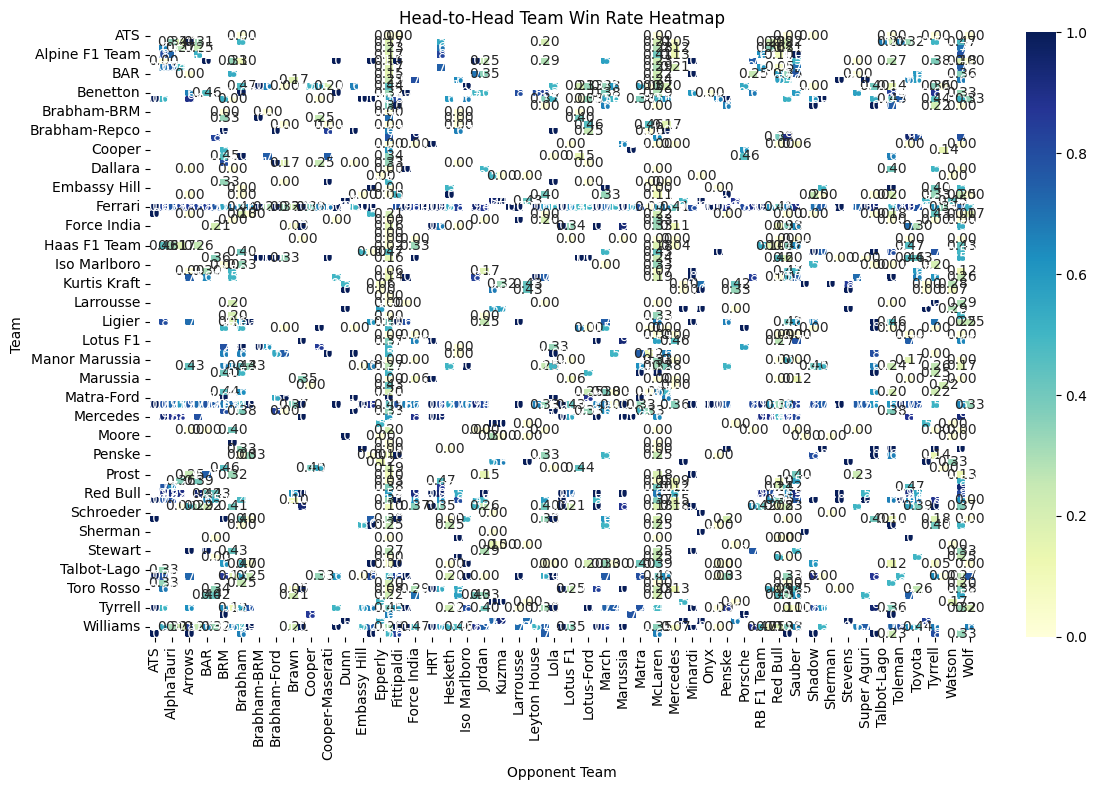

In [18]:
heatmap_data = team_performance.pivot(index="constructorName", 
                                        columns="constructorName_opponent", 
                                        values="win_rate_against")

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Head-to-Head Team Win Rate Heatmap")
plt.xlabel("Opponent Team")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


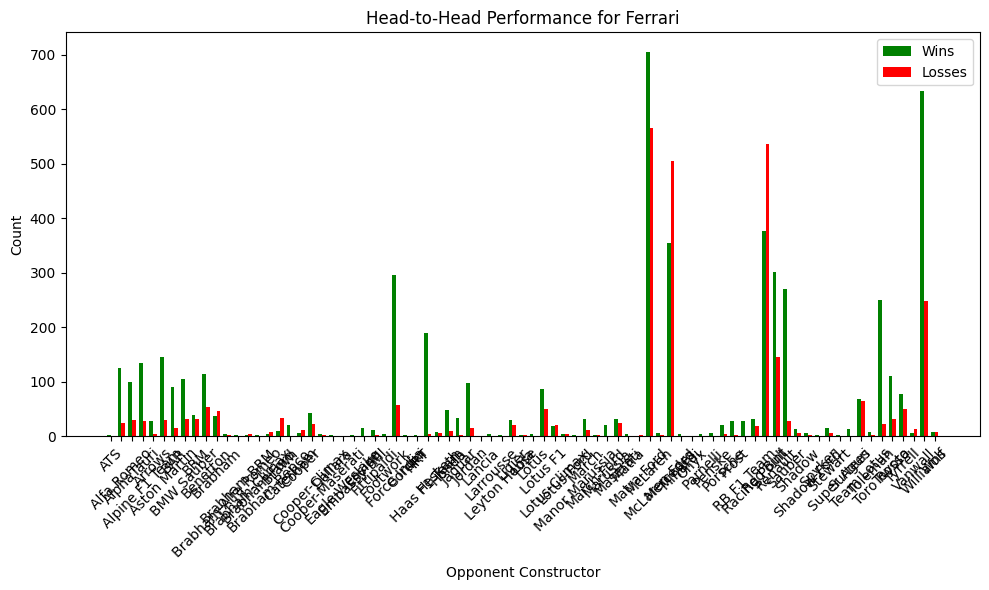

In [19]:
selected_team = "Ferrari"
team_data = team_performance[team_performance['constructorName'] == selected_team]

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(team_data))

# Plot wins and losses side by side for each opponent
plt.bar([p - bar_width/2 for p in x], team_data['wins_against'], width=bar_width, label="Wins", color='green')
plt.bar([p + bar_width/2 for p in x], team_data['losses_against'], width=bar_width, label="Losses", color='red')

plt.xticks(x, team_data['constructorName_opponent'], rotation=45)
plt.xlabel("Opponent Constructor")
plt.ylabel("Count")
plt.title(f"Head-to-Head Performance for {selected_team}")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_1075818/1856527380.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


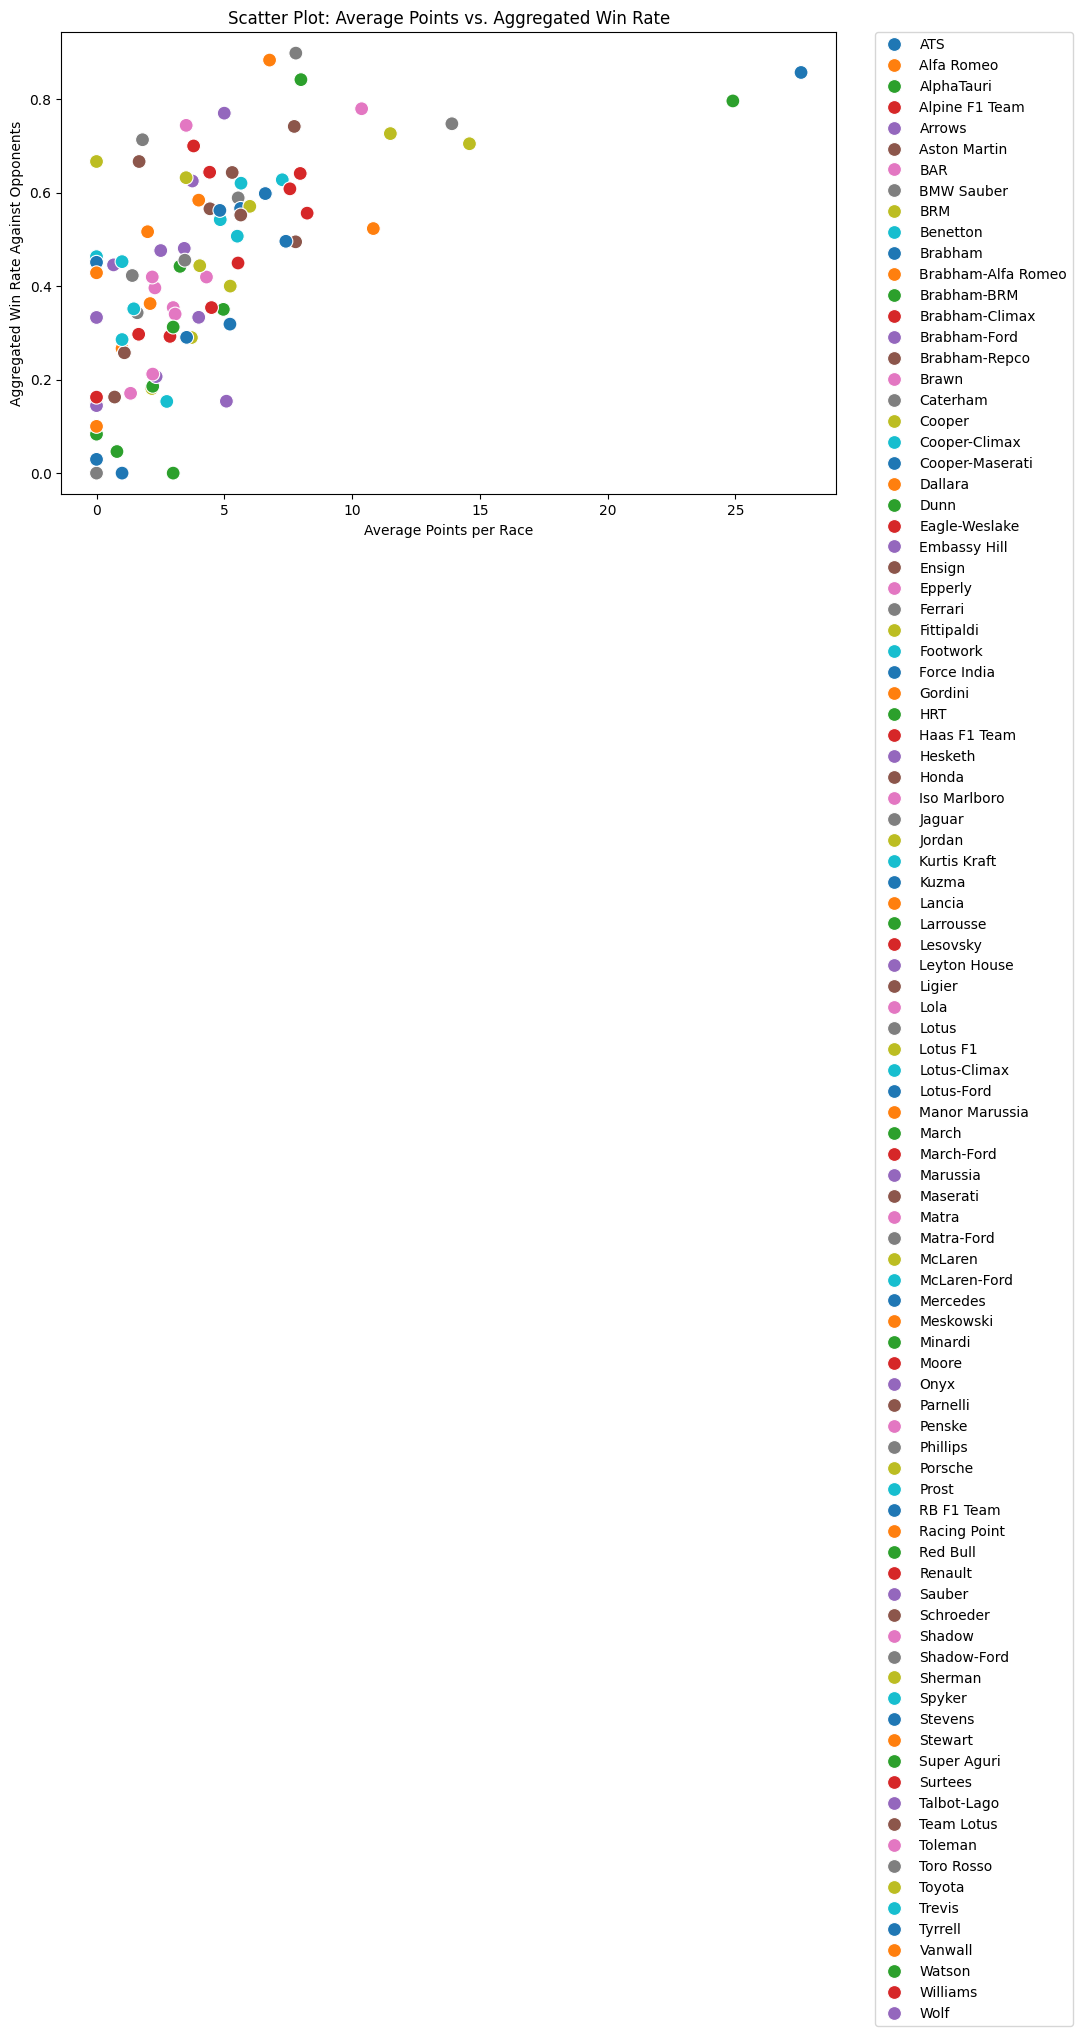

In [20]:
aggregated_data = team_performance.groupby("constructorName").agg({
    "win_rate_against": "mean",
    "constructor_avg_points": "first"
}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=aggregated_data, 
                x="constructor_avg_points", 
                y="win_rate_against", 
                hue="constructorName", 
                s=100, palette="tab10")

plt.title("Scatter Plot: Average Points vs. Aggregated Win Rate")
plt.xlabel("Average Points per Race")
plt.ylabel("Aggregated Win Rate Against Opponents")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

##### Performing Statistical test To determine That The circuit affects The head-to head performance

#### perform Two way Anova

##### Multiple Linear Regression Results